In [1]:
!pip install dgl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 24.1 MB/s eta 0:00:00


In [2]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 6.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910454 sha256=b7382a56b8e322ec0d6dfc8bf5e191db47f89e29bfa5db2efa0edf01044be9a3
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch_geometric


## Import thư viện + data

In [3]:
import itertools
import os
import random

os.environ["DGLBACKEND"] = "pytorch"

import dgl
from dgl.data import DGLDataset
import pandas as pd
import numpy as np
import scipy.sparse as sp
import torch
import torch.nn as nn
import torch.nn.functional as F

## Prepare Data

In [4]:
dataset_name = "link_prediction"
nodes_data_path = "/content/drive/Othercomputers/My Laptop/Shopee/fraud_shopee/node.txt"
edges_data_path = "/content/drive/Othercomputers/My Laptop/Shopee/fraud_shopee/egdes.txt"

In [5]:
nodes_data = pd.read_csv(nodes_data_path)
edges_data = pd.read_csv(edges_data_path)

In [6]:
# Mapping ID
id_map = {}
for i, id in enumerate(nodes_data['user'].unique()):
  id_map[id] = i
nodes_data["user"] = nodes_data["user"].apply(lambda x: id_map[x])
edges_data['Source'] = edges_data["Source"].apply(lambda x: id_map[x])
edges_data['Target'] = edges_data["Target"].apply(lambda x: id_map[x])

In [8]:
edges_data.to_csv("./edges_mapping.csv", index = False)

In [10]:
nodes_data.to_csv("./nodes_mapping.csv", index = False)

In [12]:
import os.path as osp
import random
import pandas as pd
import torch
from torch_geometric.data import InMemoryDataset, Data


class LinkPredictionDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None):
        super(LinkPredictionDataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return ["nodes_mapping.csv", "edges_mapping.csv"]

    @property
    def processed_file_names(self):
        return ["data.pt"]

    def download(self):
        pass

    def process(self):
        nodes_data = pd.read_csv(osp.join(self.raw_dir, "nodes_mapping.csv"))
        edges_data = pd.read_csv(osp.join(self.raw_dir, "edges_mapping.csv"))
        print("Heloo")
        node_features1 = torch.from_numpy(nodes_data["degree"].to_numpy())
        print(node_features1)
        node_features2 = torch.from_numpy(nodes_data["clustering"].to_numpy())
        print(node_features2)
        node_features = torch.stack([node_features1, node_features2], dim=1)
        print(node_features)

        edges_src = torch.from_numpy(edges_data["Source"].to_numpy())
        edges_dst = torch.from_numpy(edges_data["Target"].to_numpy())

        data = Data(x=node_features, edge_index=torch.stack([edges_src, edges_dst]))

        # Create a train/test split for link prediction
        n_edges = edges_data.shape[0]
        n_train = int(n_edges * 0.8)
        train_edges = random.sample(range(n_edges), n_train)
        test_edges = list(set(range(n_edges)) - set(train_edges))
        train_mask = torch.zeros(n_edges, dtype=torch.bool)
        train_mask[train_edges] = True
        test_mask = torch.zeros(n_edges, dtype=torch.bool)
        test_mask[test_edges] = True

        # Create negative samples for the test set
        n_test_neg = len(test_edges)
        test_neg_src = []
        test_neg_dst = []
        edge_index = data.edge_index
        while len(test_neg_src) < n_test_neg:
            u, v = random.sample(range(nodes_data.shape[0]), 2)
            has_edge = ((edge_index[0] == u) & (edge_index[1] == v)).any()
            if not has_edge:
                test_neg_src.append(u)
                test_neg_dst.append(v)

        data.train_pos_edge_index = data.edge_index[:, train_mask]
        data.test_pos_edge_index = data.edge_index[:, test_mask]
        data.test_neg_edge_index = torch.stack([torch.tensor(test_neg_src), torch.tensor(test_neg_dst)])

        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        torch.save(self.collate([data]), self.processed_paths[0])

if osp.exists(osp.join("./", "processed", "data.pt")):
    os.remove(osp.join("./", "processed", "data.pt"))
dataset = LinkPredictionDataset(root="./")
data = dataset[0]
dataset[0]

Processing...


Heloo
tensor([2, 4, 7,  ..., 1, 1, 1])
tensor([1.0000, 1.0000, 0.3810,  ..., 0.0000, 0.0000, 0.0000],
       dtype=torch.float64)
tensor([[2.0000, 1.0000],
        [4.0000, 1.0000],
        [7.0000, 0.3810],
        ...,
        [1.0000, 0.0000],
        [1.0000, 0.0000],
        [1.0000, 0.0000]], dtype=torch.float64)


Done!


Data(x=[58652, 2], edge_index=[2, 59289], train_pos_edge_index=[2, 47431], test_pos_edge_index=[2, 11858], test_neg_edge_index=[2, 11858])

In [13]:
data.x.shape

torch.Size([58652, 2])

## GNNs Model

In [33]:
import torch
from torch.nn import Parameter, Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling

class LinkPredictionModel(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(LinkPredictionModel, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)
        self.lin = Linear(num_classes, 1)

    def forward(self, x, edge_index):
        x = x.double()
        x = self.conv1(x, edge_index)
        # print(x)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = self.lin(x)
        x = torch.sigmoid(x)
        return x

def train(model, data, optimizer):
    model.train()
    optimizer.zero_grad()

    # Negative sampling for link prediction
    edge_index = data.train_pos_edge_index
    neg_edge_index = negative_sampling(
        edge_index, num_nodes = data.num_nodes,
        num_neg_samples=edge_index.size(1))

    x = model(data.x, edge_index)
    pos_loss = -torch.log(torch.sigmoid((x[edge_index[0]] * x[edge_index[1]]).sum(dim=-1) + 1e-15)).mean()
    neg_loss = -torch.log(1 - torch.sigmoid((x[neg_edge_index[0]] * x[neg_edge_index[1]]).sum(dim=-1)) + 1e-15).mean()
    loss = pos_loss + neg_loss
    loss.backward()
    optimizer.step()
    return loss

def test(model, data):
    model.eval()

    with torch.no_grad():
        x = model(data.x, data.edge_index)

        pos_edge_index = data.test_pos_edge_index
        neg_edge_index = data.test_neg_edge_index

        pos_score = (x[pos_edge_index[0]] * x[pos_edge_index[1]]).sum(dim=-1)
        neg_score = (x[neg_edge_index[0]] * x[neg_edge_index[1]]).sum(dim=-1)

        y_pred = torch.cat([pos_score, neg_score]).numpy()
        y_true = torch.cat([torch.ones(pos_score.size(0)), torch.zeros(neg_score.size(0))]).numpy()

        return y_pred, y_true

# Load your data object here
data = data

model = LinkPredictionModel(num_features=data.num_features,
                            hidden_channels=16,
                            num_classes=16)

model.conv1.lin.weight = torch.nn.Parameter(model.conv1.lin.weight.double())
model.conv1.bias = torch.nn.Parameter(model.conv1.bias.double())
model.conv2.lin.weight = torch.nn.Parameter(model.conv2.lin.weight.double())
model.conv2.bias = torch.nn.Parameter(model.conv2.bias.double())
model.lin.weight = torch.nn.Parameter(model.lin.weight.double())
model.lin.bias = torch.nn.Parameter(model.lin.bias.double())

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

from sklearn.metrics import roc_auc_score, accuracy_score

loss_list = []
auc_list = []

for epoch in range(200):
    loss = train(model, data, optimizer)
    y_pred, y_true = test(model, data)
    auc_score = roc_auc_score(y_true, y_pred)
    print(f'Epoch: {epoch:03d}, AUC: {auc_score:.4f}, Loss:{loss}')

    loss_list.append(loss.item())
    auc_list.append(auc_score)


Epoch: 000, AUC: 0.6945, Loss:1.34007154342591
Epoch: 001, AUC: 0.6952, Loss:1.3381049117674166
Epoch: 002, AUC: 0.6962, Loss:1.3339189604341826
Epoch: 003, AUC: 0.6992, Loss:1.3304726255226293
Epoch: 004, AUC: 0.7022, Loss:1.3277395905790803
Epoch: 005, AUC: 0.7057, Loss:1.3223441887636347
Epoch: 006, AUC: 0.7093, Loss:1.3176825012581586
Epoch: 007, AUC: 0.7103, Loss:1.3136354939147172
Epoch: 008, AUC: 0.7104, Loss:1.30712315676344
Epoch: 009, AUC: 0.7054, Loss:1.3008706414001319
Epoch: 010, AUC: 0.7041, Loss:1.294101916522701
Epoch: 011, AUC: 0.7041, Loss:1.2863168331740775
Epoch: 012, AUC: 0.7046, Loss:1.2799398745370414
Epoch: 013, AUC: 0.7052, Loss:1.2718588234805277
Epoch: 014, AUC: 0.7058, Loss:1.263897769738905
Epoch: 015, AUC: 0.7064, Loss:1.256353965199017
Epoch: 016, AUC: 0.7067, Loss:1.2491870997270973
Epoch: 017, AUC: 0.7069, Loss:1.2418510780012155
Epoch: 018, AUC: 0.7070, Loss:1.233947240960296
Epoch: 019, AUC: 0.7069, Loss:1.2286731932287038
Epoch: 020, AUC: 0.7069, Los

In [34]:
model

LinkPredictionModel(
  (conv1): GCNConv(2, 16)
  (conv2): GCNConv(16, 16)
  (lin): Linear(in_features=16, out_features=1, bias=True)
)

In [35]:
data.x

tensor([[2.0000, 1.0000],
        [4.0000, 1.0000],
        [7.0000, 0.3810],
        ...,
        [1.0000, 0.0000],
        [1.0000, 0.0000],
        [1.0000, 0.0000]], dtype=torch.float64)

In [36]:
data.edge_index

tensor([[    0,     0,     1,  ..., 42807, 42808, 42810],
        [   46, 48136, 25443,  ..., 58648, 58649, 58651]])

In [37]:
data

Data(x=[58652, 2], edge_index=[2, 59289], train_pos_edge_index=[2, 47431], test_pos_edge_index=[2, 11858], test_neg_edge_index=[2, 11858])

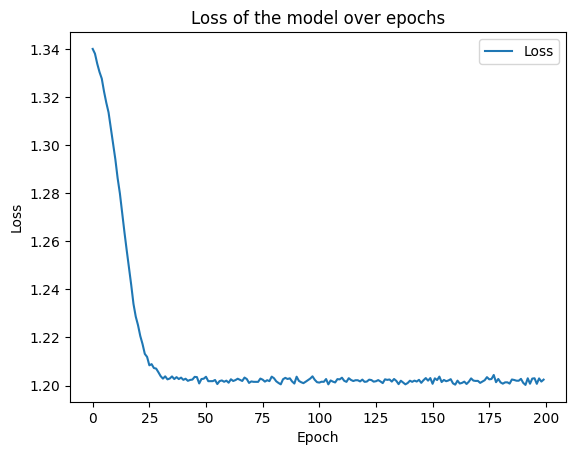

In [38]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(loss_list, label='Loss')
# ax.plot(auc_list, label='AUC')
ax.set_title('Loss of the model over epochs')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

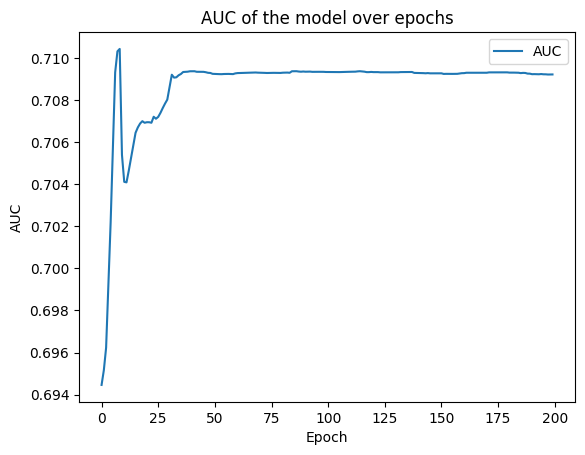

In [39]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
# ax.plot(loss_list, label='Loss')
ax.plot(auc_list, label='AUC')
ax.set_title('AUC of the model over epochs')
ax.set_xlabel('Epoch')
ax.set_ylabel('AUC')
ax.legend()
plt.show()

## Predict link

In [40]:
def predict_link(model, data, node1, node2):
    node1 = id_map[node1]
    node2 = id_map[node2]
    with torch.no_grad():
        x = model(data.x, data.edge_index)
        print(x)
        score = (x[node1] * x[node2]).sum()
        prob = torch.sigmoid(score)
        return prob.item()


In [41]:
model(data.x, data.edge_index)

tensor([[1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        ...,
        [2.8411e-05],
        [1.1745e-03],
        [2.8411e-05]], dtype=torch.float64, grad_fn=<SigmoidBackward0>)

In [42]:
model.forward(data.x, data.edge_index).shape

torch.Size([58652, 1])

In [43]:
predict_link(model, data, 33152428, 8802740)

tensor([[1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        ...,
        [2.8411e-05],
        [1.1745e-03],
        [2.8411e-05]], dtype=torch.float64)


0.7310581906431854

In [44]:
predict_link(model, data, 112991722, 23931250)

tensor([[1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        ...,
        [2.8411e-05],
        [1.1745e-03],
        [2.8411e-05]], dtype=torch.float64)


0.5000000005731171

### Những cạnh là Fraud!

In [45]:
predict_link(model, data, 221232712, 66353306)

tensor([[1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        ...,
        [2.8411e-05],
        [1.1745e-03],
        [2.8411e-05]], dtype=torch.float64)


0.5000000005731171

In [46]:
predict_link(model, data, 235599454, 51098362)

tensor([[1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        ...,
        [2.8411e-05],
        [1.1745e-03],
        [2.8411e-05]], dtype=torch.float64)


0.5000000005731171

In [47]:
predict_link(model, data, 155985518, 133103872)

tensor([[1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        ...,
        [2.8411e-05],
        [1.1745e-03],
        [2.8411e-05]], dtype=torch.float64)


0.5000000005731171

In [48]:
predict_link(model, data, 235599454, 51098362)

tensor([[1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        ...,
        [2.8411e-05],
        [1.1745e-03],
        [2.8411e-05]], dtype=torch.float64)


0.5000000005731171